### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

1/Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [4]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

#### Сначала проработаю модель с бустингом

Нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [7]:
final_transformers_boost = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers_boost.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer_boost = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers_boost.append((cont_col, cont_transformer_boost))

Объединим все это в единый пайплайн

In [8]:
feats_boost = FeatureUnion(final_transformers_boost)

feature_processing_boost = Pipeline([('feats', feats_boost)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline_boost = Pipeline([
    ('features',feats_boost),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

Обучим модель

In [10]:
#обучим наш пайплайн
pipeline_boost.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [11]:
#наши прогнозы для тестовой выборки
preds_boost = pipeline_boost.predict_proba(X_test)[:, 1]
preds_boost[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [12]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [13]:
precision_b, recall_b, thresholds_b = precision_recall_curve(y_test, preds_boost)

fscore_b = (2 * precision_b * recall_b) / (precision_b + recall_b)
# locate the index of the largest f score
ix = np.argmax(fscore_b)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_b[ix], 
                                                                        fscore_b[ix],
                                                                        precision_b[ix],
                                                                        recall_b[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Отрисуем матрицу ошибок

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


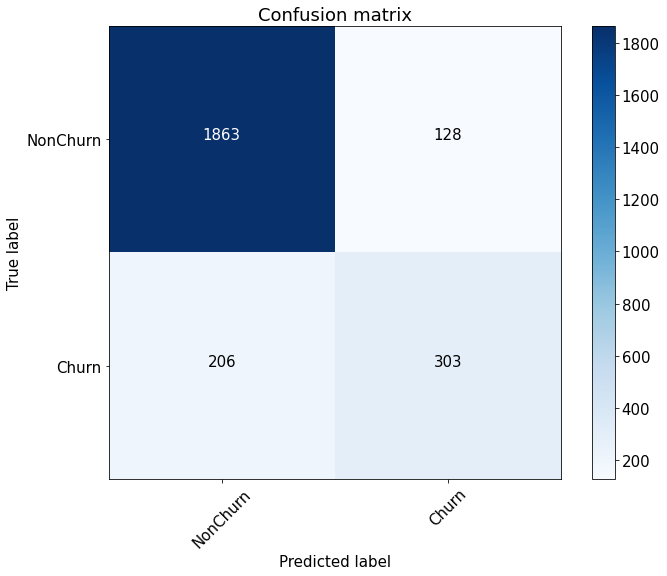

In [16]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_b = confusion_matrix(y_test, preds_boost>thresholds_b[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_b, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### Логистическая регрессия

In [17]:
from sklearn.preprocessing import StandardScaler

final_transformers_log = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers_log.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer_log = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers_log.append((cont_col, cont_transformer_log))

In [18]:
feats_log = FeatureUnion(final_transformers_log)

feature_processing_log = Pipeline([('feats', feats_log)])

In [19]:
from sklearn.linear_model import LogisticRegression

pipeline_log = Pipeline([
    ('features LR',feats_log),
    ('classifier LR', LogisticRegression(random_state = 42)),
])

In [20]:
pipeline_log.fit(X_train, y_train)

Pipeline(steps=[('features LR',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
        

In [21]:
preds_log = pipeline_log.predict_proba(X_test)[:, 1]
preds_log[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [22]:
precision_l, recall_l, thresholds_l = precision_recall_curve(y_test, preds_log)

fscore_l = (2 * precision_l * recall_l) / (precision_l + recall_l)

# locate the index of the largest f score
ix = np.argmax(fscore_l)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_l[ix], 
                                                                        fscore_l[ix],
                                                                        precision_l[ix],
                                                                        recall_l[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


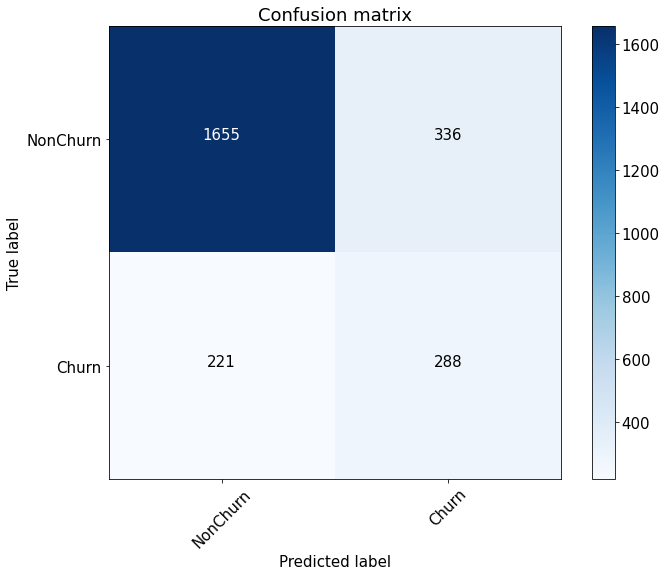

In [23]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_l = confusion_matrix(y_test, preds_log>thresholds_l[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_l, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Мне очевидно, что модель Градиентного Бустинга более эффективно подходит для решения задачи, чем Логистическая Регрессия. Ну уровне F score - 0,646 против 0,51

Для того, чтобы определить, какая метрика нам подходит больше, нам нужно на уровне выше (бизнеса) определить, что для нас критичнее - избежать ошибки 1 или 2. 

#### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [29]:
TN = cnf_matrix_b[0][0]
FN = cnf_matrix_b[1][0]
TP = cnf_matrix_b[1][1]
FP = cnf_matrix_b[0][1]

In [33]:
def efficiency(tn, fn, tp, fp):
    #sum = 2*(tn + fn) - (tp + fp)
    sum = 2*tp - (tp + fp)
    return sum

In [34]:
efficiency(TN, FN, TP, FP)

1657

Кажется, выгода есть.. 

#### Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [198]:
pipeline_boost = Pipeline([
    ('features',feats_boost),
    ('classifier', GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,
                                              min_samples_split=2, min_samples_leaf=3,  max_depth=5, 
                                              max_features=12, random_state = 42))
])

In [199]:
pipeline_boost.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [200]:
preds_boost = pipeline_boost.predict_proba(X_test)[:, 1]
preds_boost[:10]

array([0.25811831, 0.22563934, 0.20341501, 0.07075396, 0.04637765,
       0.82587559, 0.04431862, 0.06125313, 0.19920818, 0.82960998])

In [201]:
precision_b, recall_b, thresholds_b = precision_recall_curve(y_test, preds_boost)

fscore_b = (2 * precision_b * recall_b) / (precision_b + recall_b)
# locate the index of the largest f score
ix = np.argmax(fscore_b)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_b[ix], 
                                                                        fscore_b[ix],
                                                                        precision_b[ix],
                                                                        recall_b[ix]))

Best Threshold=0.315201, F-Score=0.646, Precision=0.617, Recall=0.678


Изменением гиперпараметров добилась улучшения показателей. Recall существенно выше в этой модели

Confusion matrix, without normalization
[[1777  214]
 [ 165  344]]


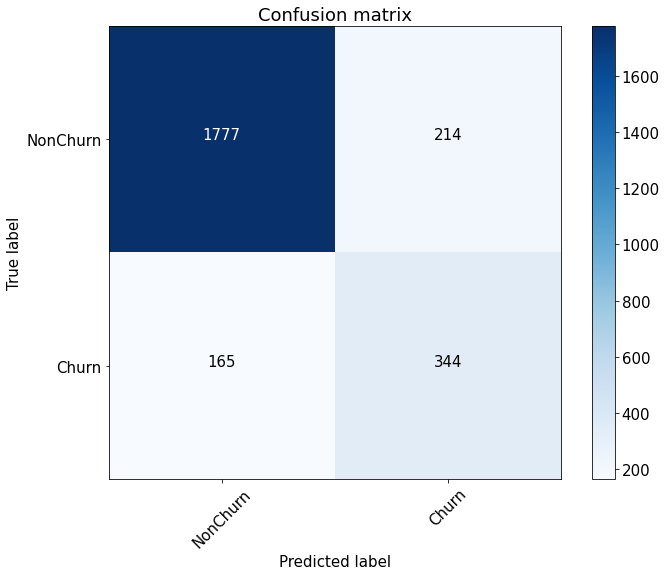

In [203]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_b = confusion_matrix(y_test, preds_boost>thresholds_b[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_b, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [204]:
TN = cnf_matrix_b[0][0]
FN = cnf_matrix_b[1][0]
TP = cnf_matrix_b[1][1]
FP = cnf_matrix_b[0][1]

In [205]:
efficiency(TN, FN, TP, FP)

130

Хм.. судя по второму подсчету экономическая эффективность на грани... 